In [ ]:
import gdown
import tarfile
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from PIL import Image
import tensorflow as tf
from keras.regularizers import l2
import cv2 as cv
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.backend import expand_dims
from tensorflow import concat
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Layer,Dropout,GRU
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import repeat
from sklearn.utils import shuffle
import nltk.translate.bleu_score as bleu
import warnings
warnings.filterwarnings('ignore')

In [ ]:
url = 'https://drive.google.com/uc?id=1U7D9lnjH-0CaXzhmua2rMtmdgS4DEH2k'
output = 'proccessed.pkl'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1U7D9lnjH-0CaXzhmua2rMtmdgS4DEH2k
To: /content/proccessed.pkl
100%|██████████| 58.1M/58.1M [00:00<00:00, 82.4MB/s]


'proccessed.pkl'

In [ ]:
url = 'https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7'
output = 'NLMCXR_png.tgz'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7
From (redirected): https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7&confirm=t&uuid=eff63665-6ad5-4e7d-835d-0cc1b99143db
To: /content/NLMCXR_png.tgz
100%|██████████| 1.36G/1.36G [00:28<00:00, 48.2MB/s]


'NLMCXR_png.tgz'

In [ ]:
cwd = os.getcwd()
tf1 = tarfile.open('NLMCXR_png.tgz')
tf1.extractall(cwd+'/png/')

In [ ]:
data = pd.read_pickle('/content/proccessed.pkl')

In [ ]:
data.shape

(3337, 8)

In [ ]:
data.head()

,patient_id,image1,image2,findings,image_features,findings_total,dec_ip,dec_op
0,CXR3556,/content/png/CXR3556_IM-1741-1001-0001.png,/content/png/CXR3556_IM-1741-1001-0002.png,the lungs are clear. there is no pleural effus...,"[[0.00041582860285416245, 0.001570420921780169...",<start> the lungs are clear. there is no pleur...,<start> the lungs are clear. there is no pleur...,the lungs are clear. there is no pleural effus...
2,CXR32,/content/png/CXR32_IM-1511-1001.png,/content/png/CXR32_IM-1511-4001.png,the heart is normal in size. the mediastinum i...,"[[0.0005354544264264405, 0.0019668142776936293...",<start> the heart is normal in size. the media...,<start> the heart is normal in size. the media...,the heart is normal in size. the mediastinum i...
4,CXR260,/content/png/CXR260_IM-1090-1001.png,/content/png/CXR260_IM-1090-2001.png,lungs are clear bilaterally. cardiac and media...,"[[0.0002745636156760156, 0.0018877924885600805...",<start> lungs are clear bilaterally. cardiac a...,<start> lungs are clear bilaterally. cardiac a...,lungs are clear bilaterally. cardiac and media...
5,CXR1301,/content/png/CXR1301_IM-0198-1001.png,/content/png/CXR1301_IM-0198-2001.png,"heart size within normal limits, stable medias...","[[0.0005874697235412896, 0.0018448150949552655...","<start> heart size within normal limits, stabl...","<start> heart size within normal limits, stabl...","heart size within normal limits, stable medias..."
6,CXR1921,/content/png/CXR1921_IM-0598-1001.png,/content/png/CXR1921_IM-0598-2001.png,"redemonstration of moderately-inflated lungs, ...","[[0.00029747304506599903, 0.0014215346891433, ...",<start> redemonstration of moderately-inflated...,<start> redemonstration of moderately-inflated...,"redemonstration of moderately-inflated lungs, ..."


In [ ]:
X_train, X_test = train_test_split(data.values , test_size = 0.2 )

In [ ]:
X_train.shape

(2669, 8)

In [ ]:
X_test.shape

(668, 8)

In [ ]:
X_train = X_train[:-19, :]
X_test = X_test[:-18, :]

In [ ]:
X_train[:,6][15]

'<start> cardiac and mediastinal contours are within normal limits. the lungs are clear. bony structures are intact.'

In [ ]:
X_train.shape

(2650, 8)

In [ ]:
data.columns

Index(['patient_id', 'image1', 'image2', 'findings', 'image_features',
       'findings_total', 'dec_ip', 'dec_op'],
      dtype='object')

In [ ]:
t1 = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n',oov_token='OOV')
t1.fit_on_texts(X_train[:,5])
vocab_size_imp = len(t1.word_index) + 1

dec_inp = t1.texts_to_sequences(X_train[:,6])

dec_inp = pad_sequences(dec_inp, maxlen=76, padding='post')

dec_inp_cv = t1.texts_to_sequences(X_test[:,6])

dec_inp_cv = pad_sequences(dec_inp_cv, maxlen=76, padding='post')

dec_op = t1.texts_to_sequences(X_train[:,7])

dec_op = pad_sequences(dec_op, maxlen=76, padding='post')

dec_op_cv = t1.texts_to_sequences(X_test[:,7])

dec_op_cv = pad_sequences(dec_op_cv, maxlen=76, padding='post')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('t1.pickle', 'wb') as handle:
    pickle.dump(t1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp -r /content/t1.pickle /content/drive/MyDrive

In [ ]:
vocab_size_imp

1840

In [ ]:
imp1 = {}
imp2 = {}
for key,value in t1.word_index.items():
  imp1[value] = key
  imp2[key] = value

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder -- Giris degeri alir ve cikis degeri uretir
    '''

    def __init__(self,units):
        super().__init__()
        self.units = units
        self.dense = Dense(self.units,name = 'Enc_dense')


    def call(self,img):
      '''
        Bu fonksiyon, Encoderin giris dizisini ve baslangic durumunu alir, Embedding layera giris dizisinin girisini iletir ve embedding layer ciktisini encoder_ltsm'ye iletir.
        Her bir cikti hidden ve cell statetir.
      '''
      #enc_out = self.maxpool(tf.expand_dims(img,axis = 2))
      enc_out = self.dense(img)
      return enc_out


    def initialize_states(self,batch_size):
      '''
      Bir batch size verildiğinde baslangictaki initial state ve cell statei verir.
      '''
      self.batch_size  = batch_size

      self.enc_h =tf.zeros((self.batch_size, self.units))

      return self.enc_h

In [ ]:
class Attention(tf.keras.layers.Layer):
  def __init__(self,att_units):
    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()

    self.att_units = att_units

    self.w1 =  tf.keras.layers.Dense( self.att_units , name = 'w1')
    self.w2 =  tf.keras.layers.Dense( self.att_units,name = 'w2')
    self.v =  tf.keras.layers.Dense(1,name = 'v')

  def call(self,decoder_hidden_state,encoder_output):
    '''
    Attention mekanizmasi iki girdi alir, decoder'in hidden state'i ve butun encoder ciktilari.
    Scoring fonksiyonuna gore decoder hidden state ve encoder ciktilari arasindaki benzerlige gore skoru bulacagiz.
    Context vectoru elde etmek icin bu score fonksiyonu ile encoder ciktilarini carpacagiz.
    Fonksiyon bize context vectoru ve attention agirliklarini(softmax) verecek.
    '''
    self.decoder_hidden_state = decoder_hidden_state
    self.encoder_output = encoder_output


    self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)
    score = self.v(tf.nn.tanh(
              self.w1(self.decoder_hidden_state) + self.w2(self.encoder_output)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * self.encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector,attention_weights

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units  ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.dec_emb = Embedding(tar_vocab_size,embedding_dim,trainable = True , name = 'dec_embb')
      self.dec_lstm = GRU(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM")
      self.dense   = Dense(self.tar_vocab_size, name = 'one_dec')
      self.attention=Attention( self.att_units)
      self.d1 = Dropout(0.3,name = 'd1')
      self.d2 = Dropout(0.3,name = 'd2')
      self.d3 = Dropout(0.3,name = 'd3')

  @tf.function
  def call(self,input_to_decoder, encoder_output, state_h):
    '''
        Adim adim one step decoder mekanizması:
      A. Embedding layer'a input_to_decoder aktarilir ve sonra cikti alinir.
      B. encoder_output ve decoder'in hidden state'i kullanilarak context vector hesaplanir.
      C. Context vectoru A adimiyla birlestirilir.
      D. C adiminin ciktisi LSTM/GRU'ya iletilir ve decoder'in ciktisiyla hidden-cell stateleri alinir.
      E. Decoder ciktisi dense layer'a aktarilir ve ciktida sonuc saklanir.
      F. D adimindaki durumlari, E adimindaki ciktiyi ve B adimindaki attention agirliklarini dondurur
    '''
    self.input_to_decoder = input_to_decoder
    self.encoder_output = encoder_output
    self.state_h = state_h

    #A
    target_embedd           = self.dec_emb (self.input_to_decoder)     #(batch_size,1,embedingdim)
    #B
    target_embedd = self.d1(target_embedd)

    context_vector,attention_weights=self.attention(self.state_h,self.encoder_output) #context vector shape = (batch_size,att_units)
    #C
    concated = tf.concat([  tf.expand_dims(context_vector, 1),target_embedd], -1)
    concated = self.d2(concated)

    #D
    lstm_output, hs      = self.dec_lstm(concated, initial_state=self.state_h)

    lstm_output = tf.reshape(lstm_output, (-1, lstm_output.shape[2]))
    lstm_output = self.d3(lstm_output)
    #E
    op = self.dense(lstm_output)
    #op = tf.squeeze(op,[1])
    return op,hs,attention_weights,context_vector

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,att_units):
      #Gerekli degerleri ve onestepdecoder'dan objeleri olusturur
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.onestep = OneStepDecoder(self.out_vocab_size,self.embedding_dim ,self.input_length,self.dec_units,self.att_units)

    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state):

        '''
        Bos tensor dizisi olusturur, bu her adimdaki ciktilari saklar.
        Decoder girisinin uzunlugu kadar iterate eder.
          decoder_input'taki her token icin onestepdecoder'i cagirir.
          tensor dizisinde sonuclari saklar.
        Tensor dizisini dondurur.
        '''
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook

        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array

        all_outputs = tf.TensorArray(tf.float32,size =input_to_decoder.shape[1],name = 'output_arrays' )
        self.input_to_decoder = input_to_decoder
        self.encoder_output = encoder_output
        self.decoder_hidden_state = decoder_hidden_state

        for timestep in tf.range(input_to_decoder.shape[1]):
          op,hs,attention_weights,context_vector = self.onestep(self.input_to_decoder[:,timestep:timestep+1], self.encoder_output, self.decoder_hidden_state)
          self.decoder_hidden_state = hs
          all_outputs = all_outputs.write(timestep,op)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size,units):
        # Encoder ve decoder nesnesi olusturur ve softmax aktivasyon fonksiyonuyla bir dense layer baslatir.
        super().__init__()

        self.units = units
        self.out_vocab_size = out_vocab_size
        self.embedding_size_d = embedding_size_d
        self.lstm_size_d = lstm_size_d
        self.input_length_d = input_length_d
        self.batch_size = batch_size
        self.att_units = att_units

        self.encoder = Encoder(self.units)

        self.decoder = Decoder(out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units )
        self.dense   = Dense(self.out_vocab_size,name = 'enc_dec_dense')



  def call(self,data):
    '''
    Encoder state'lerini baslatir ve embedding layer'a encoder dizisini aktarir.
    Decoder baslangic degerleri encoder'in bitis degerleridir ve buna göre decoder baslatilir
    Decoder ciktisini dondurur
    '''
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    self.inputs,self.outputs = data[0], data[1]
    print("="*20, "ENCODER", "="*20)
    self.encoder_h= self.encoder.initialize_states(self.batch_size)
    self.encoder_output = self.encoder(self.inputs)
    print("-"*27)
    print("ENCODER ==> OUTPUT SHAPE",self.encoder_output.shape)
    print("ENCODER ==> HIDDEN STATE SHAPE",self.encoder_h.shape)
    print("="*20, "DECODER", "="*20)
    output= self.decoder(self.outputs,self.encoder_output,self.encoder_h)
    print("-"*27)
    print("FINAL OUTPUT SHAPE",output.shape)
    print("="*50)
    return output

In [ ]:
optimizer = tf.keras.optimizers.Adam() #Adam optimizasyon algoritması, gradient descent'in bir varyantıdır ve öğrenme oranını dinamik olarak ayarlayarak daha hızlı ve verimli bir öğrenme süreci sağlar.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy( #SparseCategoricalCrossentropy, sınıflandırma problemlerinde yaygın olarak kullanılan bir kayıp fonksiyonudur.
    from_logits=True, reduction='none') #from_logits=True parametresi, modelin çıktılarının softmax fonksiyonundan geçmemiş ham skorlar olduğunu belirtir.
#reduction='none' parametresi ise kayıp değerlerinin her bir örnek için ayrı ayrı hesaplanacağını ve daha sonra toplu olarak işleneceğini belirtir.

def loss_function(real, pred): #gerçek etiketler ve modelin tahmin ettiği etiketler arasındaki kaybı hesaplar.
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #gerçek etiketlerdeki padding olmayan değerleri belirlemek için bir maske oluşturur. Bu maske, sıfır olan yerlerde False, diğer yerlerde True olur.
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask #yalnızca sıfır olmayan etiketlerin kaybını hesaplamak için maskeyi kullanır yani padding değerlerinin kayıp hesaplamasına dahil edilmemesini sağlar.

  return tf.reduce_mean(loss_) #tüm örnekler üzerindeki ortalama kaybı döner.

In [ ]:
!mkdir checkpoint

mkdir: cannot create directory ‘checkpoint’: File exists


In [ ]:
checkpoint_filepath = cwd + '/' + 'checkpoint' + '/'

In [ ]:
checkpoint_filepath

'/content/checkpoint/'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  #False olarak ayarlandığında, modelin hem ağırlıkları hem de mimarisi kaydedilir.
    monitor='val_loss', #Modelin doğrulama kaybı (val_loss) izlenir. Eğitim sürecinde bu metrik değerlere göre en iyi model belirlenir.
    verbose = 1, #Eğitim sırasında checkpoint kaydedildiğinde bilgi mesajlarının konsolda gösterilmesini sağlar. 0 olursa sessiz modda çalışır, 1 olursa mesajlar gösterilir.
    mode='min', #İzlenen metriğin minimum değerine göre modelin en iyi olduğunu belirler. Örneğin, kaybın (loss) mümkün olduğunca düşük olması istenir. Eğer mode='max' olsaydı, izlenen metriğin maksimum değerine göre en iyi model belirlenirdi.
    save_best_only=True) #True olarak ayarlandığında, sadece izlenen metrikte (bu durumda val_loss) en iyi değeri elde eden model kaydedilir.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,mode = 'min',verbose = 1,
                              patience=2, min_lr=0.0001)
#ReduceLROnPlateau, eğitim sürecinde belirli bir metrik iyileşmediğinde öğrenme oranını azaltarak modelin daha iyi optimize edilmesine yardımcı olur.
#İzlenecek metrik doğrulama kaybıdır (val_loss) ve mode='min' ile minimum değeri iyileşmediğinde azaltılır
#factor=0.8 ile öğrenme oranını %20 azaltır
#patience=2 ile val_loss iki dönem boyunca iyileşmezse öğrenme oranı azaltılır.
#Öğrenme oranı min_lr=0.0001 değerinden daha aşağıya düşemez.

In [ ]:
model_1 = encoder_decoder(vocab_size_imp,300,76,256,64,50,256)
optimizer = tf.keras.optimizers.Adam()
model_1.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
train_inp = np.vstack(X_train[:,4]).astype(float)
test_inp = np.vstack(X_test[:,4]).astype(float)

In [ ]:
model_1.fit([train_inp,dec_inp ],dec_op ,validation_data= ([test_inp, dec_inp_cv],dec_op_cv),batch_size= 50,epochs  = 40,callbacks=[reduce_lr,model_checkpoint_callback] , shuffle=True)

Epoch 1/40
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (50, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (50, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)
53/53 [==============================] - ETA: 0s - loss: 2.2787==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (50, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)

Epoch 1: val_loss improved from inf to 2.11003, saving model to /content/checkpoint/
==================== ENCODER =============

==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 105s 2s/step - loss: 2.2787 - val_loss: 2.1100 - lr: 0.0010
Epoch 2/40
53/53 [==============================] - ETA: 0s - loss: 2.1520
Epoch 2: val_loss improved from 2.11003 to 2.09238, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 97s 2s/step - loss: 2.1520 - val_loss: 2.0924 - lr: 0.0010
Epoch 3/40
53/53 [==============================] - ETA: 0s - loss: 2.1171
Epoch 3: val_loss improved from 2.09238 to 2.03191, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 93s 2s/step - loss: 2.1171 - val_loss: 2.0319 - lr: 0.0010
Epoch 4/40
53/53 [==============================] - ETA: 0s - loss: 2.0395
Epoch 4: val_loss improved from 2.03191 to 1.94240, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 2.0395 - val_loss: 1.9424 - lr: 0.0010
Epoch 5/40
53/53 [==============================] - ETA: 0s - loss: 1.8883
Epoch 5: val_loss improved from 1.94240 to 1.68541, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 1.8883 - val_loss: 1.6854 - lr: 0.0010
Epoch 6/40
53/53 [==============================] - ETA: 0s - loss: 1.5244
Epoch 6: val_loss improved from 1.68541 to 1.32040, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 94s 2s/step - loss: 1.5244 - val_loss: 1.3204 - lr: 0.0010
Epoch 7/40
53/53 [==============================] - ETA: 0s - loss: 1.2469
Epoch 7: val_loss improved from 1.32040 to 1.13706, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 100s 2s/step - loss: 1.2469 - val_loss: 1.1371 - lr: 0.0010
Epoch 8/40
53/53 [==============================] - ETA: 0s - loss: 1.1073
Epoch 8: val_loss improved from 1.13706 to 1.05093, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 94s 2s/step - loss: 1.1073 - val_loss: 1.0509 - lr: 0.0010
Epoch 9/40
53/53 [==============================] - ETA: 0s - loss: 1.0242
Epoch 9: val_loss improved from 1.05093 to 0.99031, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 94s 2s/step - loss: 1.0242 - val_loss: 0.9903 - lr: 0.0010
Epoch 10/40
53/53 [==============================] - ETA: 0s - loss: 0.9612
Epoch 10: val_loss improved from 0.99031 to 0.95629, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 93s 2s/step - loss: 0.9612 - val_loss: 0.9563 - lr: 0.0010
Epoch 11/40
53/53 [==============================] - ETA: 0s - loss: 0.9149
Epoch 11: val_loss improved from 0.95629 to 0.92679, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 97s 2s/step - loss: 0.9149 - val_loss: 0.9268 - lr: 0.0010
Epoch 12/40
53/53 [==============================] - ETA: 0s - loss: 0.8770
Epoch 12: val_loss improved from 0.92679 to 0.90293, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 96s 2s/step - loss: 0.8770 - val_loss: 0.9029 - lr: 0.0010
Epoch 13/40
53/53 [==============================] - ETA: 0s - loss: 0.8463
Epoch 13: val_loss improved from 0.90293 to 0.89001, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 96s 2s/step - loss: 0.8463 - val_loss: 0.8900 - lr: 0.0010
Epoch 14/40
53/53 [==============================] - ETA: 0s - loss: 0.8169
Epoch 14: val_loss improved from 0.89001 to 0.87696, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 98s 2s/step - loss: 0.8169 - val_loss: 0.8770 - lr: 0.0010
Epoch 15/40
53/53 [==============================] - ETA: 0s - loss: 0.7932
Epoch 15: val_loss improved from 0.87696 to 0.86100, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 96s 2s/step - loss: 0.7932 - val_loss: 0.8610 - lr: 0.0010
Epoch 16/40
53/53 [==============================] - ETA: 0s - loss: 0.7699
Epoch 16: val_loss improved from 0.86100 to 0.85241, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 96s 2s/step - loss: 0.7699 - val_loss: 0.8524 - lr: 0.0010
Epoch 17/40
53/53 [==============================] - ETA: 0s - loss: 0.7514
Epoch 17: val_loss improved from 0.85241 to 0.84439, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 96s 2s/step - loss: 0.7514 - val_loss: 0.8444 - lr: 0.0010
Epoch 18/40
53/53 [==============================] - ETA: 0s - loss: 0.7344
Epoch 18: val_loss improved from 0.84439 to 0.83887, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 0.7344 - val_loss: 0.8389 - lr: 0.0010
Epoch 19/40
53/53 [==============================] - ETA: 0s - loss: 0.7170
Epoch 19: val_loss improved from 0.83887 to 0.83346, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 0.7170 - val_loss: 0.8335 - lr: 0.0010
Epoch 20/40
53/53 [==============================] - ETA: 0s - loss: 0.7011
Epoch 20: val_loss improved from 0.83346 to 0.82879, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 99s 2s/step - loss: 0.7011 - val_loss: 0.8288 - lr: 0.0010
Epoch 21/40
53/53 [==============================] - ETA: 0s - loss: 0.6869
Epoch 21: val_loss improved from 0.82879 to 0.82526, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 0.6869 - val_loss: 0.8253 - lr: 0.0010
Epoch 22/40
53/53 [==============================] - ETA: 0s - loss: 0.6740
Epoch 22: val_loss improved from 0.82526 to 0.82018, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 94s 2s/step - loss: 0.6740 - val_loss: 0.8202 - lr: 0.0010
Epoch 23/40
53/53 [==============================] - ETA: 0s - loss: 0.6623
Epoch 23: val_loss improved from 0.82018 to 0.81232, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 94s 2s/step - loss: 0.6623 - val_loss: 0.8123 - lr: 0.0010
Epoch 24/40
53/53 [==============================] - ETA: 0s - loss: 0.6518
Epoch 24: val_loss did not improve from 0.81232
53/53 [==============================] - 91s 2s/step - loss: 0.6518 - val_loss: 0.8170 - lr: 0.0010
Epoch 25/40
53/53 [==============================] - ETA: 0s - loss: 0.6405
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 25: val_loss did not improve from 0.81232
53/53 [==============================] - 85s 2s/step - loss: 0.6405 - val_loss: 0.8135 - lr: 0.0010
Epoch 26/40
53/53 [==============================] - ETA: 0s - loss: 0.6269
Epoch 26: val_loss improved from 0.81232 to 0.80824, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---

==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 0.6269 - val_loss: 0.8082 - lr: 8.0000e-04
Epoch 27/40
53/53 [==============================] - ETA: 0s - loss: 0.6180
Epoch 27: val_loss did not improve from 0.80824
53/53 [==============================] - 89s 2s/step - loss: 0.6180 - val_loss: 0.8093 - lr: 8.0000e-04
Epoch 28/40
53/53 [==============================] - ETA: 0s - loss: 0.6100
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 28: val_loss did not improve from 0.80824
53/53 [==============================] - 90s 2s/step - loss: 0.6100 - val_loss: 0.8143 - lr: 8.0000e-04
Epoch 29/40
53/53 [==============================] - ETA: 0s - loss: 0.5994
Epoch 29: val_loss improved from 0.80824 to 0.80750, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ===========

==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 93s 2s/step - loss: 0.5994 - val_loss: 0.8075 - lr: 6.4000e-04
Epoch 30/40
53/53 [==============================] - ETA: 0s - loss: 0.5933
Epoch 30: val_loss improved from 0.80750 to 0.80696, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 0.5933 - val_loss: 0.8070 - lr: 6.4000e-04
Epoch 31/40
53/53 [==============================] - ETA: 0s - loss: 0.5887
Epoch 31: val_loss did not improve from 0.80696
53/53 [==============================] - 89s 2s/step - loss: 0.5887 - val_loss: 0.8083 - lr: 6.4000e-04
Epoch 32/40
53/53 [==============================] - ETA: 0s - loss: 0.5823
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 32: val_loss did not improve from 0.80696
53/53 [==============================] - 84s 2s/step - loss: 0.5823 - val_loss: 0.8086 - lr: 6.4000e-04
Epoch 33/40
53/53 [==============================] - ETA: 0s - loss: 0.5755
Epoch 33: val_loss did not improve from 0.80696
53/53 [==============================] - 88s 2s/step - loss: 0.5755 - val_loss: 0.8112 - lr: 5.1200e-04
Epoch 34/40
53/53 [==============================] - ETA: 0s - loss: 0.5714
Epoch 34: val_loss improved from 0.80696 to 0.80541, savin

==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 0.5714 - val_loss: 0.8054 - lr: 5.1200e-04
Epoch 35/40
53/53 [==============================] - ETA: 0s - loss: 0.5667
Epoch 35: val_loss did not improve from 0.80541
53/53 [==============================] - 90s 2s/step - loss: 0.5667 - val_loss: 0.8063 - lr: 5.1200e-04
Epoch 36/40
53/53 [==============================] - ETA: 0s - loss: 0.5627
Epoch 36: val_loss improved from 0.80541 to 0.80496, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 0.5627 - val_loss: 0.8050 - lr: 5.1200e-04
Epoch 37/40
53/53 [==============================] - ETA: 0s - loss: 0.5587
Epoch 37: val_loss improved from 0.80496 to 0.80457, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 96s 2s/step - loss: 0.5587 - val_loss: 0.8046 - lr: 5.1200e-04
Epoch 38/40
53/53 [==============================] - ETA: 0s - loss: 0.5560
Epoch 38: val_loss did not improve from 0.80457
53/53 [==============================] - 89s 2s/step - loss: 0.5560 - val_loss: 0.8066 - lr: 5.1200e-04
Epoch 39/40
53/53 [==============================] - ETA: 0s - loss: 0.5510
Epoch 39: val_loss improved from 0.80457 to 0.80395, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1852)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1852)


53/53 [==============================] - 95s 2s/step - loss: 0.5510 - val_loss: 0.8039 - lr: 5.1200e-04
Epoch 40/40
53/53 [==============================] - ETA: 0s - loss: 0.5461
Epoch 40: val_loss did not improve from 0.80395
53/53 [==============================] - 89s 2s/step - loss: 0.5461 - val_loss: 0.8078 - lr: 5.1200e-04


In [ ]:
model_1.load_weights(checkpoint_filepath)

In [ ]:
def beam(sentence):
  """ Bu fonksiyon beam search kullanarak cumleyi tahmin eder """

  initial_state=model_1.layers[0].initialize_states(1)
  encoder_output= model_1.layers[0](sentence) #başlangıç cümlesi encodera verilir
  result = ''

  sequences = [['<start>' ,initial_state, 0]] #Her dizi, '<start>' tokenı, başlangıç durumu ve başlangıç skoruyla (0) başlar.

  decoder_hidden_state = initial_state

  #cur_vec = np.ones((1, 1)) * imp2['<start>']
  #cur_vec = np.array([[1]])
  finished_seq = []
  beam_width = 3 #Beam Search sırasında tutulacak en iyi seçeneklerin sayısını belirtir.

  for i in range(76): # Cümlenin maksimum uzunluğuna kadar döner
    all_candidates = [] #O anki beam'de tutulan tüm aday cümleler ve skorları saklanır.
    new_seq = []
    for s in sequences:

      cur_vec = np.reshape(imp2[s[0].split(" ")[-1]],(1,1))
      decoder_hidden_state = s[1]
      op,hs,attention_weights,context_vector = model_1.layers[1].onestep(cur_vec, encoder_output, decoder_hidden_state) #Her bir beam'deki son token için yeni tokenlar tahmin edilir,
      op = tf.nn.softmax(op) #softmax uygulanır
      top3 = np.argsort(op).flatten()[-beam_width:] #en yüksek olasılıklı tokenlar seçilir
      for t in top3: #Yeni tahmin edilen tokenlar mevcut cümleye eklenir ve yeni skorlara göre aday cümleler güncellenir.

         candidates = [s[0] + ' '+ imp1[t], hs,s[2]-np.log(np.array(op).flatten()[t])]
         all_candidates.append(candidates)
    sequences = sorted(all_candidates, key = lambda l: l[2])[:beam_width]

    count = 0
    for s1 in sequences:
      if s1[0].split(" ")[-1] == '<end>':


        s1[2] = s1[2]/len(s1[0])   # normalized
        finished_seq.append([s1[0], s1[1],s1[2]])
        count+=1
      else:

        new_seq.append([s1[0], s1[1],s1[2]])

    beam_width -= count
    sequences = new_seq
    if not sequences:
      break
    else:
      continue

  if len(finished_seq) >0:
    sequences = finished_seq[-1]
    return sequences[0]
  else:
    return new_seq[-1][0]

In [ ]:
data.columns

Index(['patient_id', 'image1', 'image2', 'findings', 'image_features',
       'findings_total', 'dec_ip', 'dec_op'],
      dtype='object')

Original Sentence is :  <start> both lungs are clear and epanded. heart and mediastinum normal.
Predicted Sentence is :  <start> the lungs are clear effusions cardiomegaly. no evidence of focal acute pneumothora or pleural effusion. specifically mediastinal airspace is thoracic seen. osseous structures of the soft are mild consolidation upper there is no consolidation unremarkable. distal contour. <end>


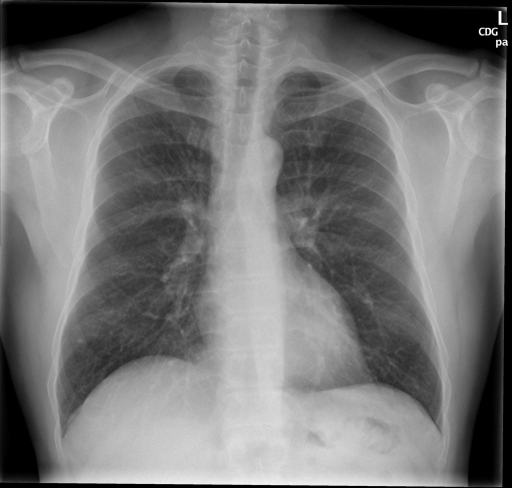

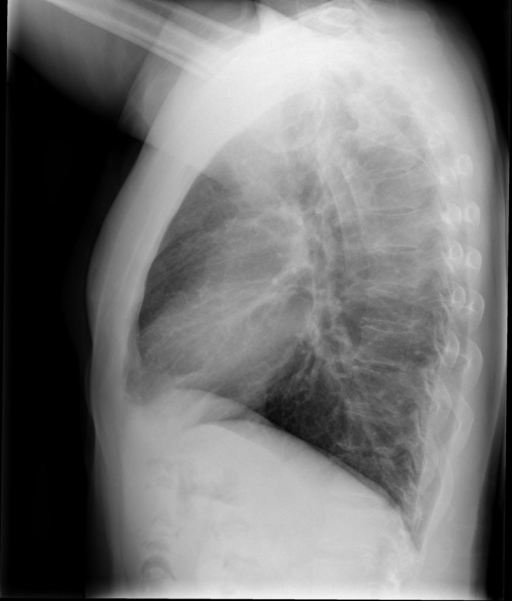

In [ ]:
num = 1 #random test sample
im_o = np.vstack(X_test[:,4][num]).astype(float)
tex_o = X_test[:,6][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
from skimage.transform import resize

def load_image(img_name):
  """Loads image in array format"""

  image = Image.open(img_name)
  X = np.asarray(image.convert("RGB"))
  X = np.asarray(X)
  X = preprocess_input(X)
  X = resize(X, (224,224,3))
  X = np.expand_dims(X, axis=0)
  X = np.asarray(X)

  return X

In [ ]:
url = 'https://drive.google.com/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b'
output = 'chexnet.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b
To: /content/chexnet.h5
100%|██████████| 29.1M/29.1M [00:00<00:00, 191MB/s]


'chexnet.h5'

In [ ]:
chexnet = DenseNet121(weights=cwd+'/chexnet.h5', classes = 14,input_shape=(224,224,3))
model = Model(chexnet.input, chexnet.layers[-2].output)


def image_extractor(image_name):
  i1 = load_image(image_name)
  img1_features = model.predict(i1)
  img1_features = np.vstack(img1_features).astype(float)

  img2_features = model.predict(i1)
  img2_features = np.vstack(img2_features).astype(float)

  conc = np.concatenate((img1_features, img2_features), axis=1)
  return conc

In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!ngrok authtoken 2h0Xb9TkE2GXLj7ejwhTOjjm5tU_21QzP3xSS3i33XZErRLq4

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from fastapi import FastAPI, File, UploadFile
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from fastapi.responses import JSONResponse
import io
import base64

class Item(BaseModel):
    image: str

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

@app.get('/')
async def root():
    return {'hello': 'world'}

@app.post('/predict')
async def upload_image(image: Item):
  try:
    base64_string=image.image.replace("data:image/jpeg;base64,","")
    decoded_data=base64.b64decode((base64_string))
    img_file = open('image.jpg', 'wb')
    img_file.write(decoded_data)
    img_file.close()
    image_feature = image_extractor('image.jpg')
    im_o = np.vstack(image_feature).astype(float)
    tex_o = X_test[:,5][num]
    predict_sentence = beam(im_o)
    return JSONResponse(content={"predict": predict_sentence})
  except Exception as e:
        return JSONResponse(content={"error": str(e)}, status_code=500)

In [ ]:
from pyngrok import ngrok
ngrok.kill()

In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

ngrok_tunnel = ngrok.connect(9000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, host="127.0.0.1", port=9000)


Public URL: https://4073-34-74-175-88.ngrok-free.app


INFO:     Started server process [354]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:9000 (Press CTRL+C to quit)


INFO:     193.255.169.22:0 - "OPTIONS /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 148ms/step
INFO:     193.255.169.22:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     193.255.169.22:0 - "OPTIONS /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 151ms/step
INFO:     193.255.169.22:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 146ms/step
INFO:     193.255.169.22:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     193.255.169.22:0 - "OPTIONS /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 316ms/step
INFO:     193.255.169.22:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 153ms/step
INFO:     193.255.169.22:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     193.255.169.22:0 - "OPTIONS /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 152ms/step
INFO:     193.255.169.22:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     193.255.169.22:0 - "OPTIONS /predict HTTP/1.1" 200